In [1]:
import astroalign as aa

import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import tessreduce as tr
from tessreduce import *

made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
kernels matched


<IPython.core.display.Javascript object>


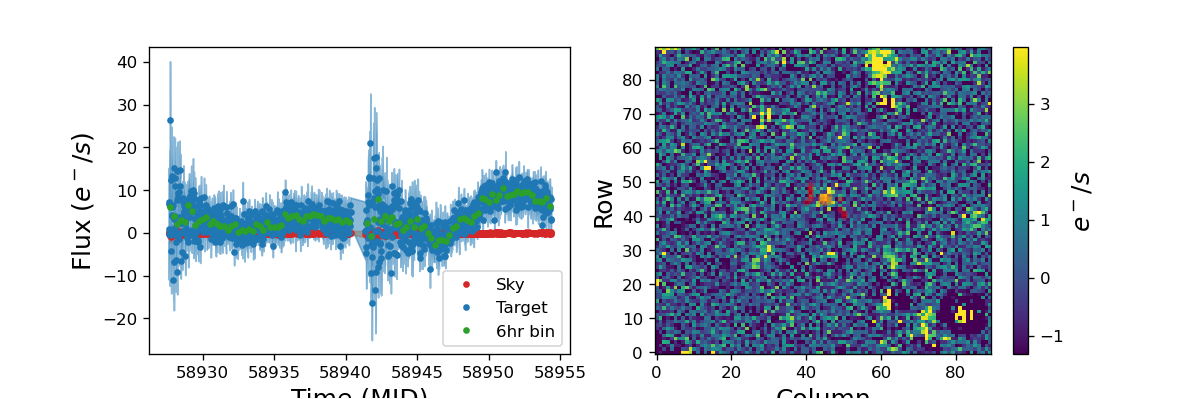

In [2]:
tess = tr.tessreduce(tpf='../../SN_individual/2020ghq/s23.fits',num_cores=-2,calibrate=False)

<IPython.core.display.Javascript object>


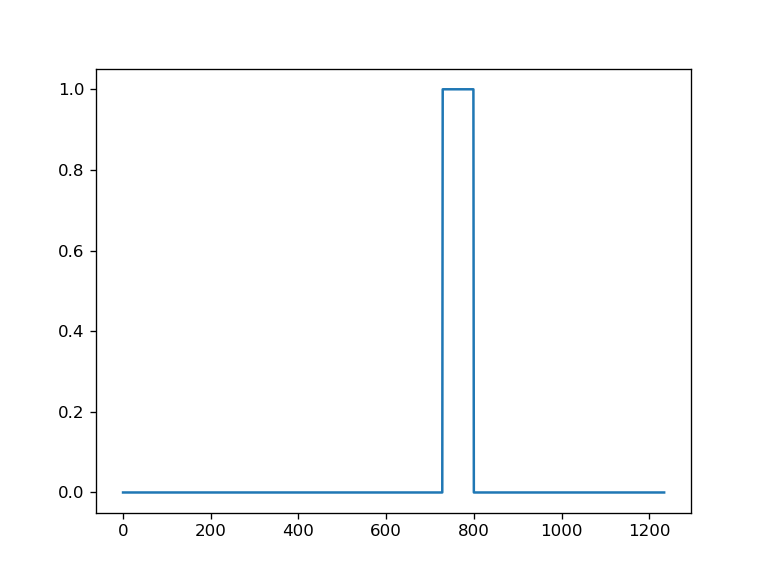

In [21]:
plt.figure()
plt.plot(tess.tpf.quality > 0)

<IPython.core.display.Javascript object>


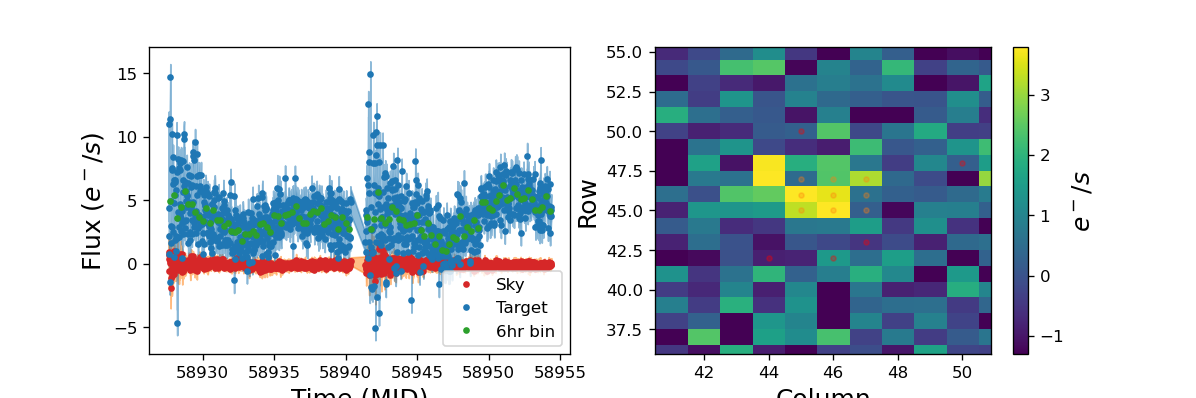

In [5]:
lc,s = tessa.diff_lc(x=46,y=46,phot_method='psf',plot=True);

<IPython.core.display.Javascript object>


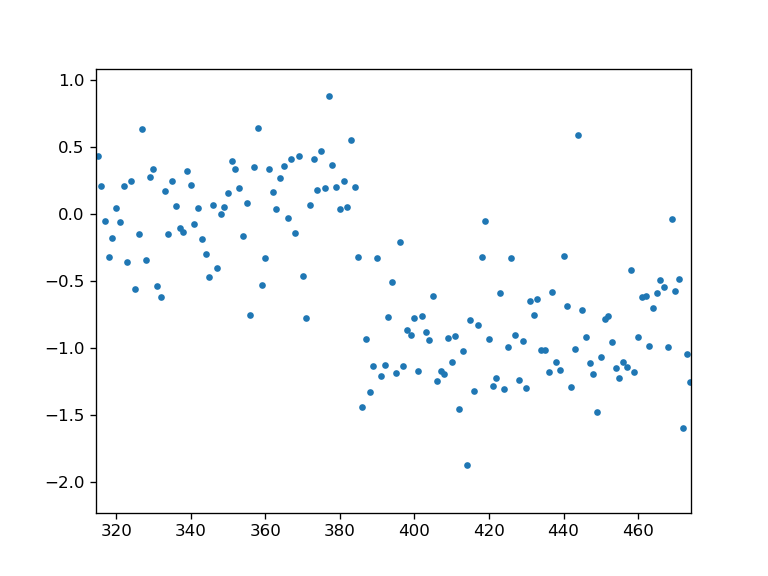

In [26]:
plt.figure()
#plt.plot(tess.flux[:,45,45],'.')
plt.plot(tess.flux[:,44,45],'.')
#plt.plot(tess.shift[:,0])

<IPython.core.display.Javascript object>


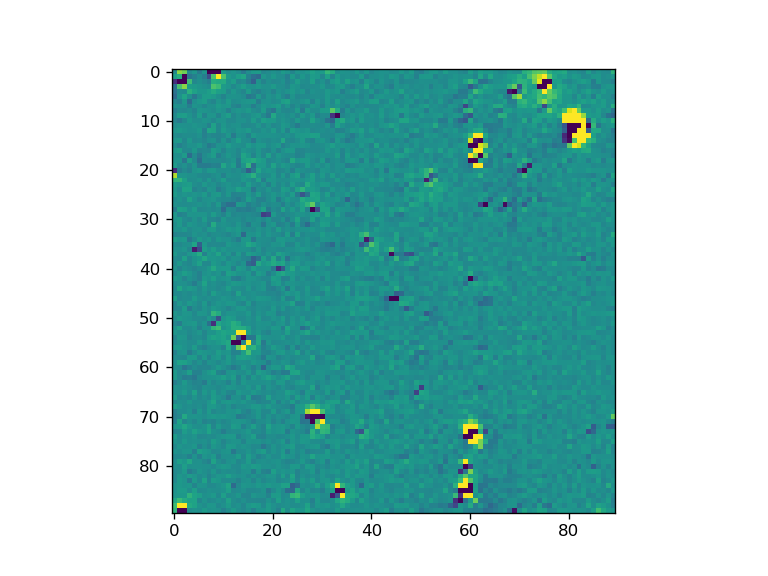

In [29]:
plt.figure()
plt.imshow(tess.flux[381]-tess.flux[387],vmax=5,vmin=-5)

<IPython.core.display.Javascript object>


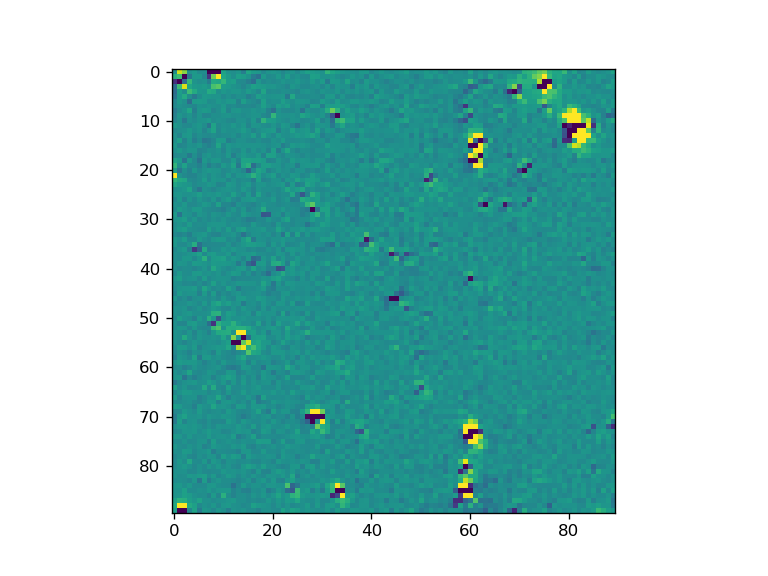

In [32]:
plt.figure()
plt.imshow(tess.flux[381],vmax=5,vmin=-5)

made reference
made source mask
calculating background
background subtracted
field calibration
target is above -30 dec, calibrating to PS1 photometry.


<IPython.core.display.Javascript object>


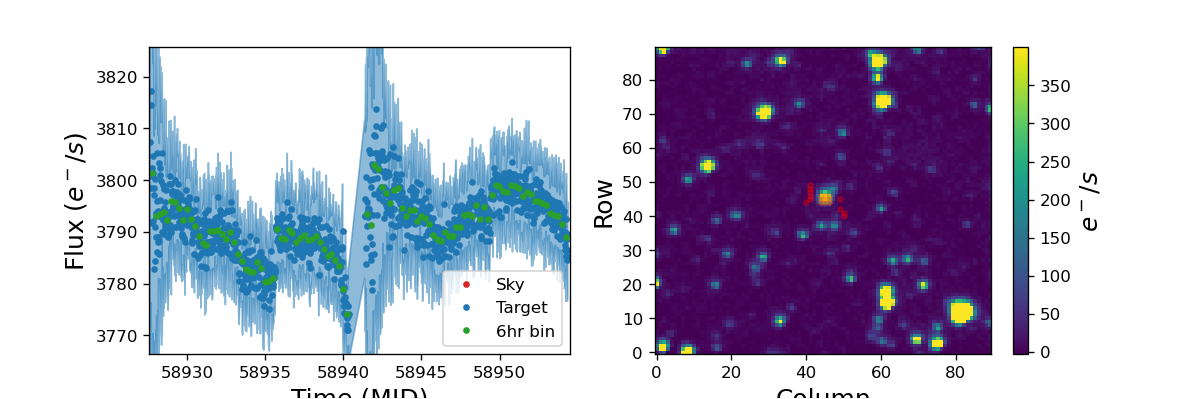

In [33]:
tess = tr.tessreduce(tpf='../../SN_individual/2020ghq/s23.fits',reduce=True,plot=True,diff=False,align=False)

In [3]:
from scipy.optimize import minimize
from scipy import signal
from astropy.convolution import Gaussian2DKernel

from scipy.optimize import minimize

def Delta_basis(Size = 13):
    kernal = np.zeros((Size,Size))
    x,y = np.where(kernal==0)
    middle = int(len(x)/2)
    basis = []
    for i in range(len(x)):
        b = kernal.copy()
        if (x[i] == x[middle]) & (y[i] == y[middle]):
            b[x[i],y[i]] = 1
        else:
            b[x[i],y[i]] = 1
            b[x[middle],y[middle]] = -1
        basis += [b]
    basis = np.array(basis)
    coeff = np.ones(len(basis))
    return basis, coeff

def Delta_kernal(Scene,Image,Size=7,mask=None):
    if mask is None:
        mask = np.ones_like(Image)
    mask[mask == 0] = np.nan
    Basis, coeff_0 = Delta_basis(Size)
    bds = []
    for i in range(len(coeff_0)):
        bds += [(0,1)]
    coeff_0 *= 0.01
    coeff_0[Size//2+1] = 0.95
    res = minimize(optimize_delta, coeff_0, args=(Basis,Scene,Image,Size,mask),
                   bounds=bds,method='Powell')
    k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
    return k
        
def optimize_delta(Coeff, Basis, Scene, Image,size,mask):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)

    template = signal.fftconvolve(Scene, Kernal, mode='same')
    
    im = Image.copy()
    
    res = np.nansum(abs(im[size//2:-size//2,size//2:-size//2]-template[size//2:-size//2,size//2:-size//2])*mask[size//2:-size//2,size//2:-size//2])
    #print(res)
    return res
    
    

In [86]:
ind = 381
flux = tess.flux
k = Delta_kernal(flux[tess.ref_ind],flux[ind],Size=9,mask=tess.mask==1)
template = signal.fftconvolve(flux[tess.ref_ind], k, mode='same')

<IPython.core.display.Javascript object>


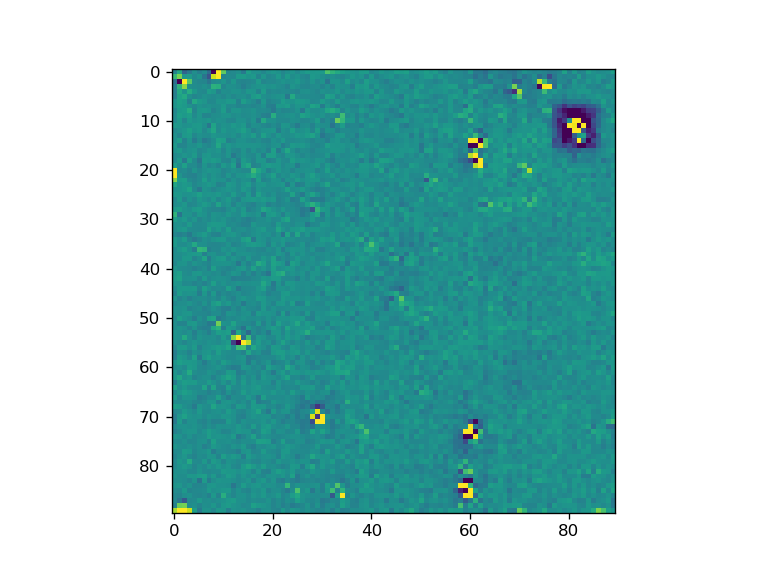

In [88]:
ind = 381
flux = tess.flux
k = Delta_kernal(flux[tess.ref_ind],flux[ind],Size=9,mask=tess.mask==1)
template = signal.fftconvolve(flux[tess.ref_ind], k, mode='same')
plt.figure()
plt.imshow(flux[ind]- template,vmax=5,vmin=-5)

In [4]:
ind = 365
flux = tessa.flux + tessa.ref
k = Delta_kernal(flux[tessa.ref_ind],flux[ind],Size=11,mask=tess.mask==1)
template = signal.fftconvolve(tessa.ref, k, mode='same')

#k2 = Delta_kernal(flux[ind],flux[tessa.ref_ind],Size=9,mask=tess.mask==1)
#matched = signal.fftconvolve(flux[ind], k2, mode='same')

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(tessa.flux[ind],vmax=5,vmin=-5)
plt.subplot(122)
plt.imshow(flux[ind] - template,vmax=5,vmin=-5)
#plt.subplot(133)
#plt.imshow(matched - flux[tessa.ref_ind],vmax=5,vmin=-5)

NameError: name 'tess' is not defined

In [11]:
from copy import deepcopy

In [14]:
thingo = deepcopy(tess.flux)
for i in range(len(tess.flux)):
    thingo[i],_ = aa.register(tess.flux[i],tess.ref)

<IPython.core.display.Javascript object>


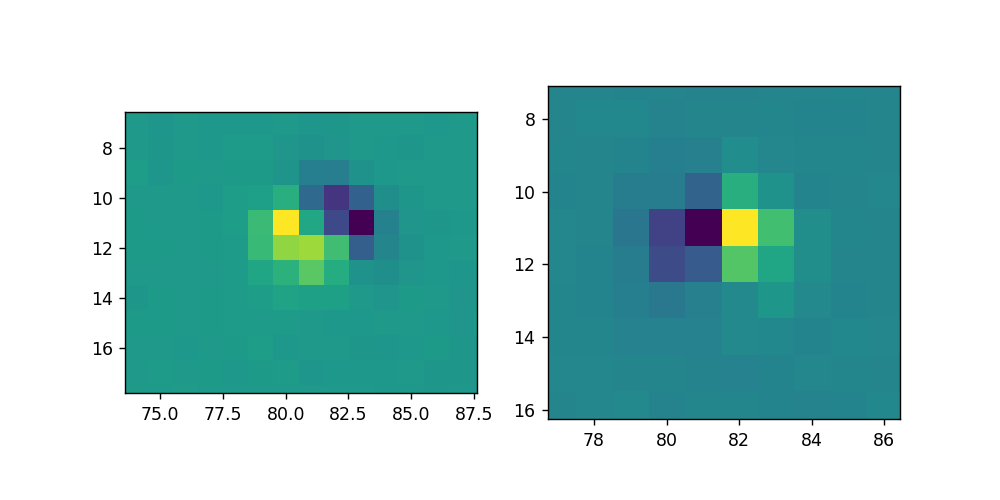

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(thingo[10]-thingo[tess.ref_ind])
plt.subplot(122)
plt.imshow(tess.flux[10]-tess.ref)

In [61]:
from skimage.transform import estimate_transform
import sep

In [78]:
mean, med, std = sigma_clipped_stats(tess.ref, sigma=3.0)
sources = sep.extract(tess.ref, med + 3*std, minarea=5)

In [80]:
sources.sort(order="flux")
pos = np.array([[asrc["x"], asrc["y"]] for asrc in sources[::-1]])

In [ ]:
estimate_transform()

In [28]:
from PRF import TESS_PRF
from photutils.detection import StarFinder

In [34]:
prf = TESS_PRF(tess.tpf.camera,tess.tpf.ccd,tess.tpf.sector,tess.tpf.column+45,tess.tpf.row+45)
kernel = prf.locate(5,5,(11,11))

<IPython.core.display.Javascript object>


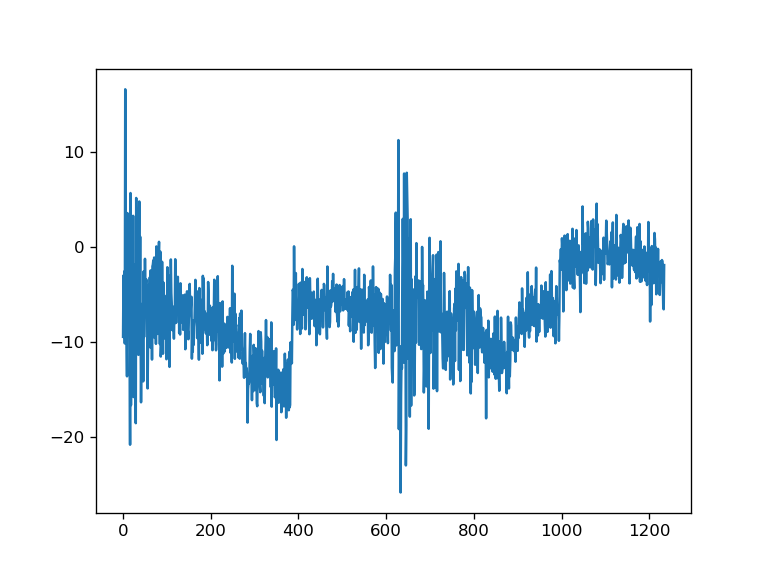

In [109]:
plt.figure()
plt.plot(tessa.lc[1])

In [87]:
ress = []
for i in range(len(tess.flux)):
    data = tess.flux[i]
    mean, med, std = sigma_clipped_stats(data, sigma=3.0)
    sources = sep.extract(data, med + 2*std, minarea=5)
    finder = StarFinder(med + 10*std,kernel=kernel)
    sources.sort(order="flux")
    pos = np.array([[asrc["x"], asrc["y"]] for asrc in sources[::-1]])
    ress += [pos]

<IPython.core.display.Javascript object>


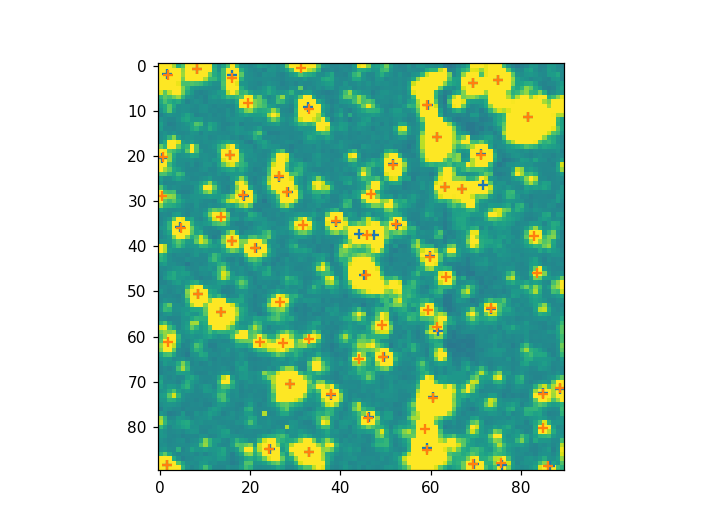

In [89]:
plt.figure()
plt.imshow(tess.ref,vmin=-10,vmax=10)
#plt.scatter(ress[100]['xcentroid'],ress[100]['ycentroid'])
#plt.scatter(ress[900]['xcentroid'],ress[900]['ycentroid'],marker='+')
plt.scatter(ress[0][:,0],ress[0][:,1],marker='+')
plt.scatter(ress[1000][:,0],ress[1000][:,1],marker='+')

id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,7.8933900742280345,0.6737629718990117,3.1924061699349906,0.6443326781442079,162.57336932270877,678.0278697592053,2676.0323361013116,-8.568728392419507
2,2.5977600091800377,1.6480443404121423,3.9889661281566458,0.650192491692941,167.91778214892872,394.03720042836676,2394.5374897299344,-8.448054102251518
3,16.130731002668377,3.050383025437614,4.286020805676688,0.3474563178178287,65.91526018830388,50.12289720389754,375.24726873515374,-6.435793849706204
4,59.78732938348027,4.801154398161997,4.870564762480848,0.2792114453482471,146.21509659839785,75.48511120094463,1158.4719562875666,-7.6597138126715345
5,74.27297470513798,3.5727986652557058,4.77209789336234,0.14858831087684976,22.48069538108036,560.9105467784234,4796.8088276245,-9.20238102601559
6,70.93414633144381,4.015612725678376,5.473948736098234,0.40981201401241835,155.75795333762542,327.63698742978295,3246.475209151736,-8.778530227116569
7,18.326946332044315,7.031600827763918,5.4024950978383135,0.3798073356949091,37.674435834132986,32.18613276439282,378.9658845142708,-6.446500288547659
...,...,...,...,...,...,...,...,...
37,45.754845194594445,77.48013035853519,6.041655099155786,0.15517048158393143,13.605611897257104,31.788717102554074,425.75697034695895,-6.572904417032523
